In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imripy import constants as c, kepler, merger_system as ms, inspiral, plot_utils as pu
from imripy.inspiral import forces
from scipy.interpolate import interp1d
import plotting

This notebook explores the braking and dephasing index for a parameterized force and tests the analytic calculations with numerics. For a circular inspiral, for an eccentric one, and one for a system with two parameterized forces.

In [2]:
# Example System
m1 = 1e3 * c.solar_mass_to_pc
m2 = 1. * c.solar_mass_to_pc

hs = ms.HostSystem(m1)

## Test Braking & Dephasing Index

In [3]:
# Example force
alpha = -1.5
beta = 1.
k_1 = 3./2. + alpha - beta/2.
print(k_1)
F_0 = 5e-28

F = forces.ParameterizedForce(alpha, beta, F_0)

-0.5


In [4]:
gw = forces.GWLoss()

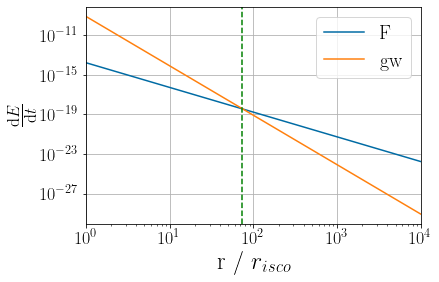

In [5]:
r_grid = np.geomspace(hs.r_isco, 1e4*hs.r_isco, 100)

opt = inspiral.Classic.EvolutionOptions(dissipativeForces={F, gw})
dE_F_dt = -np.array([F.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r), opt) for r in r_grid])
dE_gw_dt = -np.array([gw.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r), opt) for r in r_grid])
r_eq = r_grid[np.argmin(r_grid**3*np.abs(dE_F_dt - dE_gw_dt))]

plt.loglog(r_grid/hs.r_isco, dE_F_dt, label='F')
plt.loglog(r_grid/hs.r_isco, dE_gw_dt, label='gw')
#plt.loglog(r_grid/hs.r_isco, np.abs(dE_F_dt - dE_gw_dt))
plt.axvline(r_eq/hs.r_isco, linestyle='--', color='green')
plt.xlim(left=1., right=1e4)
plt.grid(); plt.legend()
plt.xlabel("r / $r_{isco}$"); plt.ylabel("$\dv{E}{t}$")
plt.savefig("plots/dephasing_index_example_dE_dt.pdf", bbox_inches="tight")

In [6]:
ko = kepler.KeplerOrbit(hs, m2, 1e3*hs.r_isco)
ev_vac = inspiral.Classic.Evolve(hs, ko, opt=inspiral.Classic.EvolutionOptions(dissipativeForces={gw}, accuracy=1e-13))
ev_F = inspiral.Classic.Evolve(hs, ko, opt=inspiral.Classic.EvolutionOptions(dissipativeForces={F, gw}, accuracy=1e-13))


Evolving from  1000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0973s real time
Evolving from  1000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, ParameterizedForce, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0854s real time


<ipython-input-7-95d728e15a36>:18: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f5c74c7f340> starts with '_'. It is thus excluded from the legend.
  axs[2].legend(["_", "_", l1.get_label(), l2.get_label()])
<ipython-input-7-95d728e15a36>:18: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f5c74b23b20> starts with '_'. It is thus excluded from the legend.
  axs[2].legend(["_", "_", l1.get_label(), l2.get_label()])


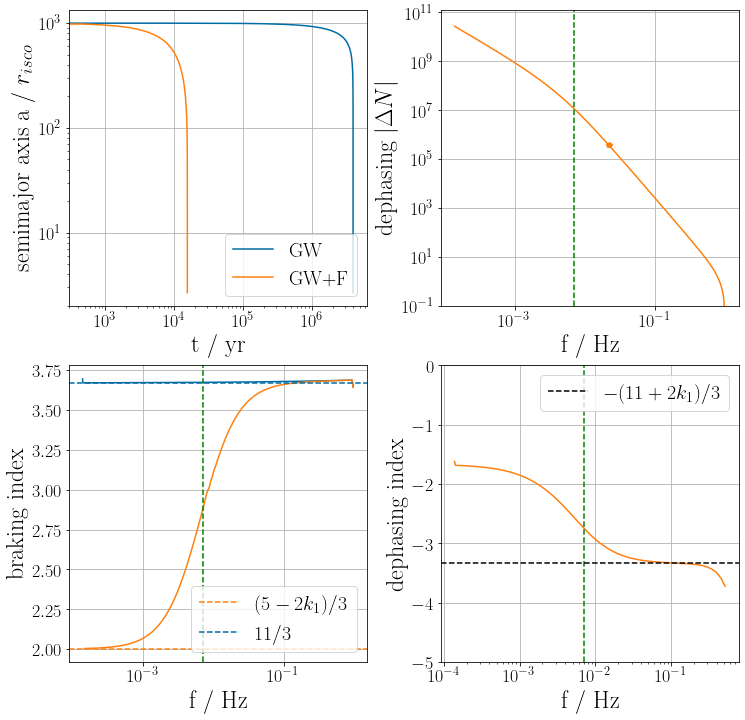

In [7]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()
lgw = pu.plotEvolution(hs, ev_vac, ax_a=axs[0], ax_n=axs[2], label='GW')
lF = pu.plotEvolution(hs, ev_F, ax_a=axs[0], ax_n=axs[2], label='GW+F')

pu.plotDeltaN(hs, ev_vac, ev_F, ax_dN=axs[1], ax_di=axs[3], plotFgw5year=True, color=lF.get_c())

f_eq = 2.* 1./2/np.pi * np.sqrt(m1/r_eq**3) # f_gw = 2 *f_orbit
axs[0].set_xlabel("t / yr"); axs[0].set_ylabel("semimajor axis a / $r_{isco}$"); axs[0].legend(loc='lower right')

axs[1].axvline(f_eq/c.hz_to_invpc, linestyle="--", color='green')
axs[1].set_ylabel("dephasing $|\Delta N|$"); axs[1].set_xlabel("f / Hz"); axs[1].set_ylim(bottom=1e-1)

l1=axs[2].axhline((5-2*k_1)/3, linestyle="--", color=lF.get_c(), label="$(5-2k_1)/3$")
l2=axs[2].axhline(11/3, linestyle="--", color=lgw.get_c(), label="$11/3$")
axs[2].axvline(f_eq/c.hz_to_invpc, linestyle="--", color='green')
axs[2].set_xscale('log'); axs[2].set_xlabel("f / Hz"); axs[2].set_ylabel("braking index"); 
axs[2].legend(["_", "_", l1.get_label(), l2.get_label()])

axs[3].axvline(f_eq/c.hz_to_invpc, linestyle="--", color='green')
axs[3].axhline(-(11+2*k_1)/3, linestyle='--', color='black', label="$-(11+2k_1)/3$"); axs[3].legend()
axs[3].set_xscale('log'); axs[3].set_ylim(bottom=-5., top=0.); axs[3].set_xlabel("f / Hz"); axs[3].set_ylabel("dephasing index")
for ax in axs:
    ax.grid()
fig.subplots_adjust(wspace=0.25)
plt.savefig("plots/dephasing_index_example.pdf", bbox_inches="tight")

### Eccentric Inspiral

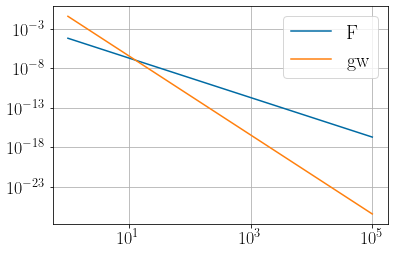

In [8]:
r_grid = np.geomspace(hs.r_isco, 1e5*hs.r_isco, 50)
e0=0.995
a0=1e3*hs.r_isco
F.F_0 = 1e-20
opt = inspiral.Classic.EvolutionOptions(dissipativeForces=[F, gw])

plt.loglog(r_grid/hs.r_isco, np.abs([F.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r, e=e0), opt) for r in r_grid]), label='F')
plt.loglog(r_grid/hs.r_isco, np.abs([gw.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r, e=e0), opt) for r in r_grid]), label='gw')
plt.grid(); plt.legend()

In [9]:
ko = kepler.KeplerOrbit(hs, m2, a0, e=e0)
ev_vac = inspiral.Classic.Evolve(hs, ko, opt=inspiral.Classic.EvolutionOptions(dissipativeForces=[gw]))
ev_F = inspiral.Classic.Evolve(hs, ko, opt=inspiral.Classic.EvolutionOptions(dissipativeForces=[F, gw]))

Evolving from  1000.0  to  1.0 r_isco  with initial eccentricity 0.995  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-10
A termination event occurred.
 -> Ended at 2.728e+00r_isco. Evolution took 0.0534s real time
Evolving from  1000.0  to  1.0 r_isco  with initial eccentricity 0.995  with  Options: dissipative forces employed {ParameterizedForce, GWLoss, }, accuracy = 1.0e-10
A termination event occurred.
 -> Ended at 3.176e+00r_isco. Evolution took 0.3109s real time


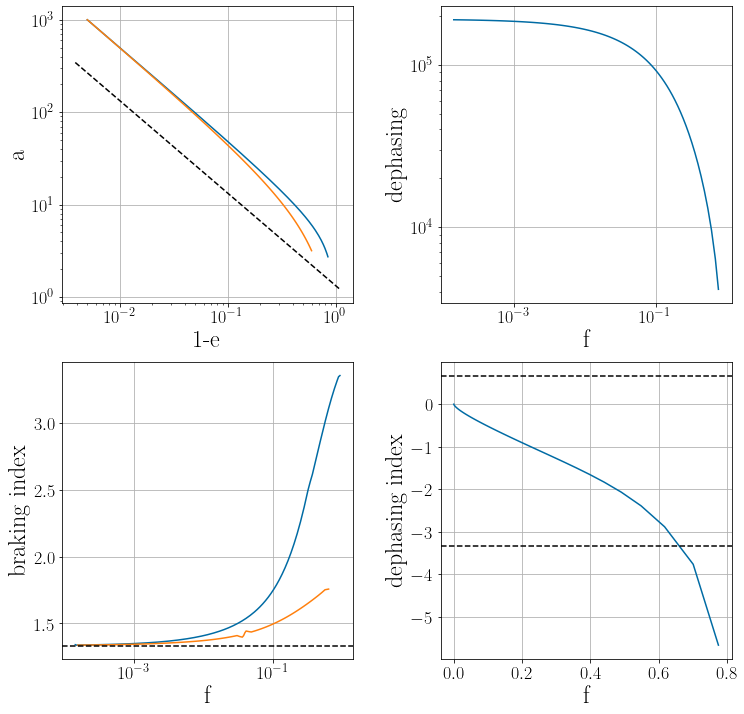

In [10]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
pu.plotEvolution(hs, ev_vac, ax_1mea=axs[0,0], ax_n=axs[1,0], label='GW')
pu.plotEvolution(hs, ev_F, ax_1mea=axs[0,0], ax_n=axs[1,0], label='GW+F')

axs[1,0].set_xscale('log');axs[1,0].axhline(4./3, linestyle='--', color='black')
e_grid = 1.-np.array(axs[0,0].get_xlim())
axs[0,0].plot(1.-e_grid, 8./6./(1.-e_grid), linestyle='--', color='black');

pu.plotDeltaN(hs, ev_vac, ev_F, ax_dN=axs[0,1], ax_di=axs[1,1])
axs[1,1].axhline((1.-2*k_1)/3, linestyle='--', color='black')
axs[1,1].axhline(-(11.+2*k_1)/3, linestyle='--', color='black')
#axs[1,1].set_xscale('log'); axs[1,1].set_ylim(top=10, bottom=-10)

axs[0,0].set_xlabel("1-e"); axs[0,0].set_ylabel("a")

axs[1,0].set_ylabel("braking index"); axs[1,0].set_xlabel("f")
axs[0,1].set_ylabel("dephasing"); axs[0,1].set_xlabel("f")
axs[1,1].set_ylabel("dephasing index"); axs[1,1].set_xlabel("f")

fig.subplots_adjust(wspace=0.3)
for ax in axs.flatten():
    ax.grid()

## Two dissipative forces

In [11]:
gw = forces.GWLoss()

In [12]:
alpha = -1.5
beta = 1.
k_1_1 = 3./2. + alpha - beta/2.
print(k_1)
F_0 = 1e-26

F1 = forces.ParameterizedForce(alpha, beta, F_0)

-0.5


In [13]:
alpha = -1.
beta = -3.
k_1_2 = 3./2. + alpha - beta/2.
print(k_1_2)
F_0 = 1e-30

F2 = forces.ParameterizedForce(alpha, beta, F_0)

2.0


Text(0, 0.5, '$\\dv{E}{t}$')

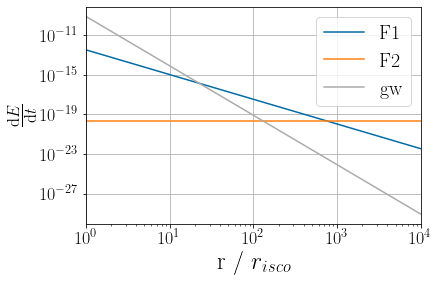

In [14]:
r_grid = np.geomspace(hs.r_isco, 1e4*hs.r_isco, 100)

opt = inspiral.Classic.EvolutionOptions(dissipativeForces={F, gw})
dE_F1_dt = -np.array([F1.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r), opt) for r in r_grid])
dE_F2_dt = -np.array([F2.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r), opt) for r in r_grid])
dE_gw_dt = -np.array([gw.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r), opt) for r in r_grid])
#r_eq = r_grid[np.argmin(r_grid**3*np.abs(dE_F_dt - dE_gw_dt))]

plt.loglog(r_grid/hs.r_isco, dE_F1_dt, label='F1')
plt.loglog(r_grid/hs.r_isco, dE_F2_dt, label='F2')
plt.loglog(r_grid/hs.r_isco, dE_gw_dt, label='gw')
#plt.loglog(r_grid/hs.r_isco, np.abs(dE_F_dt - dE_gw_dt))
#plt.axvline(r_eq/hs.r_isco, linestyle='--', color='green')
plt.xlim(left=1., right=1e4)
plt.grid(); plt.legend()
plt.xlabel("r / $r_{isco}$"); plt.ylabel("$\dv{E}{t}$")


In [15]:
ko = kepler.KeplerOrbit(hs, m2, 2e3*hs.r_isco)
ev_vac = inspiral.Classic.Evolve(hs, ko, opt=inspiral.Classic.EvolutionOptions(dissipativeForces=[gw], accuracy=1e-13))

opt_F1 = inspiral.Classic.EvolutionOptions(dissipativeForces=[F1, gw], accuracy=1e-13)
t_F1 = np.abs(inspiral.Classic.E_orbit(hs, ko, opt=opt_F1) / F1.dE_dt(hs, ko, opt=opt_F1))
ev_F1 = inspiral.Classic.Evolve(hs, ko, opt=opt_F1, t_fin = 1e2*t_F1)

opt_F2 = inspiral.Classic.EvolutionOptions(dissipativeForces=[F2, gw], accuracy=1e-13)
t_F2 = np.abs(inspiral.Classic.E_orbit(hs, ko, opt=opt_F2) / F2.dE_dt(hs, ko, opt=opt_F2))
ev_F2 = inspiral.Classic.Evolve(hs, ko, opt=opt_F2, t_fin = 1e2*t_F2)

opt_F1_F2 = inspiral.Classic.EvolutionOptions(dissipativeForces=[F1,F2, gw], accuracy=1e-13)
ev_F = inspiral.Classic.Evolve(hs, ko, t_fin=np.min([ev_F1.t[-1], ev_F2.t[-1]]) , opt=opt_F1_F2)


Evolving from  2000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.1121s real time
Evolving from  2000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {ParameterizedForce, GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.0701s real time
Evolving from  2000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {ParameterizedForce, GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.1414s real time
Evolving from  2000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {ParameterizedForce, ParameterizedForce, GWLoss, }, accuracy = 1.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.1038s real time


/media/data/Documents/PhD/imripy/src/imripy/plot_utils.py:156: RuntimeWarning: divide by zero encountered in divide
  ax_di.plot(ev_1.f_gw[:stop]/c.hz_to_invpc, (ddN_df/dN * ev_1.f_gw)[:stop], color=l.get_c(), **kwargs)
<ipython-input-16-41100126cdb3>:23: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f5c599a4f40> starts with '_'. It is thus excluded from the legend.
  axs[2].legend(["_", "_", l1.get_label(), l2.get_label(), l3.get_label()])
<ipython-input-16-41100126cdb3>:23: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f5c4deec160> starts with '_'. It is thus excluded from the legend.
  axs[2].legend(["_", "_", l1.get_label(), l2.get_label(), l3.get_label()])


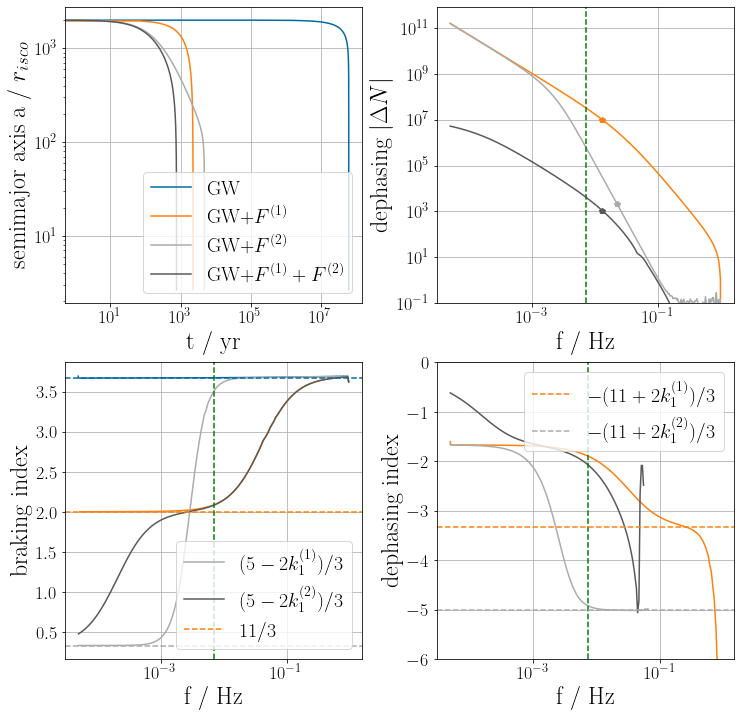

In [16]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()
lgw = pu.plotEvolution(hs, ev_vac, ax_a=axs[0], ax_n=axs[2], label='GW')
lF1 = pu.plotEvolution(hs, ev_F1, ax_a=axs[0], ax_n=axs[2], label='GW+$F^{(1)}$')
lF2 = pu.plotEvolution(hs, ev_F2, ax_a=axs[0], ax_n=axs[2], label='GW+$F^{(2)}$')
lF = pu.plotEvolution(hs, ev_F, ax_a=axs[0], ax_n=axs[2], label='GW+$F^{(1)}+F^{(2)}$')

pu.plotDeltaN(hs, ev_vac, ev_F1, ax_dN=axs[1], ax_di=axs[3], plotFgw5year=True, color=lF1.get_c())
pu.plotDeltaN(hs, ev_vac, ev_F2, ax_dN=axs[1], ax_di=axs[3], plotFgw5year=True, color=lF2.get_c())
pu.plotDeltaN(hs, ev_F1, ev_F, ax_dN=axs[1], ax_di=axs[3], plotFgw5year=True, color=lF.get_c())

#f_eq = 1./2/np.pi * np.sqrt(m1/r_eq**3)
axs[0].set_xlabel("t / yr"); axs[0].set_ylabel("semimajor axis a / $r_{isco}$"); axs[0].legend(loc='lower right')

axs[1].axvline(f_eq/c.hz_to_invpc, linestyle="--", color='green')
axs[1].set_ylabel("dephasing $|\Delta N|$"); axs[1].set_xlabel("f / Hz"); axs[1].set_ylim(bottom=1e-1)

l1=axs[2].axhline((5-2*k_1_1)/3, linestyle="--", color=lF1.get_c(), label="$(5-2k_1^{(1)})/3$")
l2=axs[2].axhline((5-2*k_1_2)/3, linestyle="--", color=lF2.get_c(), label="$(5-2k_1^{(2)})/3$")
l3=axs[2].axhline(11/3, linestyle="--", color=lgw.get_c(), label="$11/3$")
axs[2].axvline(f_eq/c.hz_to_invpc, linestyle="--", color='green')
axs[2].set_xscale('log'); axs[2].set_xlabel("f / Hz"); axs[2].set_ylabel("braking index"); 
axs[2].legend(["_", "_", l1.get_label(), l2.get_label(), l3.get_label()])

axs[3].axvline(f_eq/c.hz_to_invpc, linestyle="--", color='green')
axs[3].axhline(-(11+2*k_1_1)/3, linestyle='--', color=lF1.get_c(), label="$-(11+2k_1^{(1)})/3$");
axs[3].axhline(-(11+2*k_1_2)/3, linestyle='--', color=lF2.get_c(), label="$-(11+2k_1^{(2)})/3$");
#axs[3].axhline(-(11+2*(k_1_1+k_1_2))/3, linestyle='--', color=lF.get_c(), label="$-(11+2k_1^1+2k_1^2)/3$");
axs[3].legend()
axs[3].set_xscale('log'); axs[3].set_ylim(bottom=-6., top=0.); axs[3].set_xlabel("f / Hz"); axs[3].set_ylabel("dephasing index")
for ax in axs:
    ax.grid()
fig.subplots_adjust(wspace=0.25)
#plt.savefig("plots/dephasing_index_example.pdf", bbox_inches="tight")